### ⭐ LightGBM 모델링 전체 코드
(코드 후에 모델 꺼내기 수행)

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.5f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

In [ ]:
df = pd.read_csv("data/full_data/TPS_cancel_data_Final.csv")

In [6]:
# 2월 ~ 9월 train
# 10월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
val = df[df['p_mt'] == 10]
test = df[df['p_mt'] == 11]

# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])


# -------------------------------------------------------------------------------------------------

from sklearn.utils import resample

# 데이터 분리
df_Y = train[train['churn'] == 'Y']
df_N = train[train['churn'] == 'N']

# Y의 데이터 개수와 비율에 따른 N의 샘플 개수 계산
y_count = len(df_Y)  # Y 데이터 개수
n_count_target = int((6 / 4) * y_count)  # 6:4 비율로 N 데이터 개수 계산

# N 데이터를 랜덤 샘플링
df_N_downsampled = resample(
    df_N,
    replace=False,  # 복원 샘플링 하지 않음
    n_samples=n_count_target,  # 목표 샘플 개수
    random_state=42  # 재현성을 위한 시드
)

# 언더샘플링된 데이터 결합
train_balanced = pd.concat([df_Y, df_N_downsampled])

# 결과 섞기 (선택 사항)
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print("\n최종 데이터 분포:")
print(train_balanced['churn'].value_counts())

train = train_balanced


# -------------------------------------------------------------------------------------------------

# Train에는 없고 Validation/Test에만 있는 값 찾기 (자동화)
unseen_values = {}

categorical_cols = train.select_dtypes(include=['object']).columns

for col in categorical_cols:
    train_unique = set(train[col].unique())
    
    val_unique = set(val[col].unique())
    test_unique = set(test[col].unique())

    # Validation과 Test에서 Train에 없는 값 찾기
    unseen_val = val_unique - train_unique
    unseen_test = test_unique - train_unique

    if unseen_val or unseen_test:
        unseen_values[col] = unseen_val.union(unseen_test)  # 모든 unseen 값 저장

# ✅ Validation과 Test에서 Train에 없는 값 제거
for col, unseen_set in unseen_values.items():
    val = val[~val[col].isin(unseen_set)].reset_index(drop=True)
    test = test[~test[col].isin(unseen_set)].reset_index(drop=True)

# ✅ 필터링된 결과 확인
print("\n제거된 값 목록:", unseen_values)
print("변경 후 Validation 데이터 크기:", val.shape)
print("변경 후 Test 데이터 크기:", test.shape)

# -------------------------------------------------------------------------------------------------

# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("\n레이블 인코딩 끝")

# -------------------------------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("\nrobust, minmax 끝\n")

# -------------------------------------------------------------------------------------------------
# 모델 학습

from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=994,
    max_depth = 2,
    learning_rate=0.11383109314408676,
    num_leaves = 69,
    min_child_samples = 145,
    subsample = 0.5076849374977488,
    colsample_bytree = 0.7939112737232251,
    lambda_l1 = 4.641944310999863,
    lambda_l2 = 9.197916523794223,
    class_weight='balanced',
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

object
object
object

최종 데이터 분포:
churn
N    158559
Y    105706
Name: count, dtype: int64

제거된 값 목록: {'PROD_NM_GRP': {'기타'}, 'INHOME_RATE': {'100.0'}}
변경 후 Validation 데이터 크기: (1948644, 17)
변경 후 Test 데이터 크기: (1945585, 17)

레이블 인코딩 끝

robust, minmax 끝
[LightGBM] [Warning] lambda_l1 is set=4.641944310999863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.641944310999863
[LightGBM] [Warning] lambda_l2 is set=9.197916523794223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.197916523794223


LGBMClassifier(class_weight='balanced', colsample_bytree=0.7939112737232251,
               lambda_l1=4.641944310999863, lambda_l2=9.197916523794223,
               learning_rate=0.11383109314408676, max_depth=2,
               min_child_samples=145, n_estimators=994, num_leaves=69,
               random_state=42, subsample=0.5076849374977488)

### 레이블 인코딩 상태

##### 📌 컬럼: SCRB_PATH_NM_GRP
##### I/B: 0, O/B: 1, 기타: 2, 렌탈제휴: 3, 일반상담: 4, 임직원: 5, 전략채널: 6, 정보없음: 7, 직영몰: 8, 현장경로: 9
--------------------------------------------------
##### 📌 컬럼: CH_LAST_DAYS_BF_GRP
##### 2주일전: 0, 3개월내없음: 1, 3주일전: 2, 4주일전: 3, 일주일내: 4, 일주일전: 5
--------------------------------------------------
##### 📌 컬럼: STB_RES_1M_YN
##### N: 0, Y: 1
--------------------------------------------------
##### 📌 컬럼: AGMT_KIND_NM
##### 신규: 0, 약정갱신: 1, 약정승계: 2, 약정연장: 3, 약정축소: 4, 재약정: 5, 정보없음: 6
--------------------------------------------------
##### 📌 컬럼: BUNDLE_YN
##### N: 0, Y: 1
--------------------------------------------------
##### 📌 컬럼: AGMT_END_SEG
##### 약정만료 1개월: 0, 약정만료전 12개월이상: 1, 약정만료전 1~2개월: 2, 약정만료전 1개월: 3, 약정만료전 2~3개월: 4, 약정만료전 3~6개월: 5, 약정만료전 6~9개월: 6, 약정만료전 9~12개월: 7, 약정만료후 12개월이상: 8, 약정만료후 1개월~2개월: 9, 약정만료후 2개월~3개월: 10, 약정만료후 3~6개월: 11, 약정만료후 6~9개월: 12, 약정만료후 9~12개월: 13
--------------------------------------------------
##### 📌 컬럼: AGE_GRP10
##### 10대: 0, 20대: 1, 30대: 2, 40대: 3, 50대: 4, 60대: 5, 70대: 6, 80대: 7, 90대이상: 8, 연령없음: 9
--------------------------------------------------
##### 📌 컬럼: VOC_STOP_CANCEL_MONTH1_YN
##### N: 0, Y: 1
--------------------------------------------------
##### 📌 컬럼: PROD_NM_GRP
##### 기타: 0, 베이직: 1, 세이버: 2, 스탠다드: 3, 이코노미: 4, 프리미엄: 5
--------------------------------------------------
##### 📌 컬럼: MEDIA_NM_GRP
##### HD: 0, UHD: 1, 기타: 2
--------------------------------------------------
##### 📌 컬럼: VOC_TOTAL_MONTH1_YN
##### N: 0, Y: 1
--------------------------------------------------
##### 📌 컬럼: churn
##### N: 0, Y: 1
--------------------------------------------------


Test Performance:
Test Accuracy: 0.81
Test AUC-ROC: 0.85
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1932409
           1       0.03      0.74      0.05     13176

    accuracy                           0.81   1945585
   macro avg       0.51      0.77      0.47   1945585
weighted avg       0.99      0.81      0.89   1945585



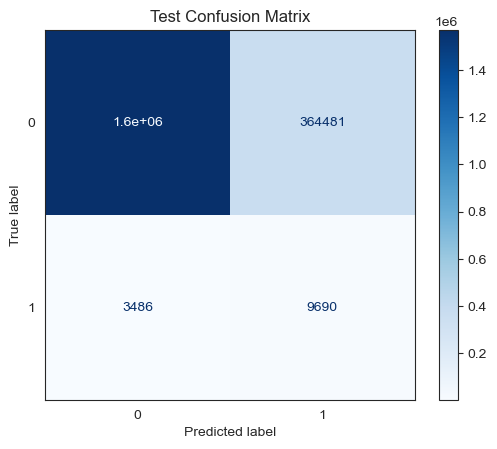

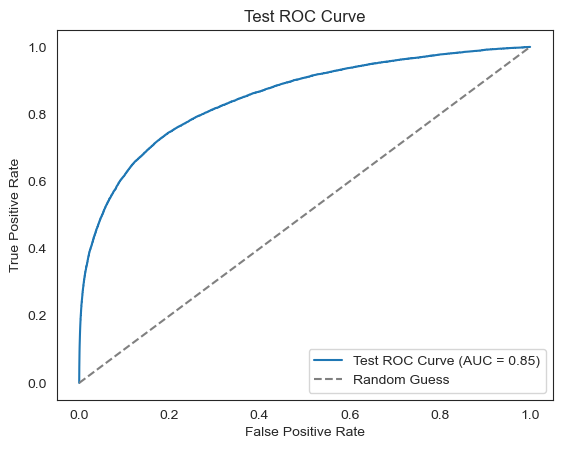

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# 4. 테스트 데이터 평가
# -----------------------------------------------------------
# 테스트 데이터 예측
# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_test = test.drop(columns=['churn'])
y_test = test['churn']

test_predictions = lgbm_model.predict(X_test)
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, test_predictions)
test_auc = roc_auc_score(y_test, test_probabilities)

print("\nTest Performance:")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test AUC-ROC: {test_auc:.2f}")
print(classification_report(y_test, test_predictions))

# Confusion Matrix 시각화
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lgbm_model.classes_)
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

### ✅ 모델 꺼내기

In [9]:
import joblib


joblib.dump(lgbm_model, 'file_pkl/lightgbm_model.pkl')
print("Model 저장")

# 스케일러 저장
joblib.dump(robust_scaler, 'file_pkl/robust_scaler.pkl')
joblib.dump(minmax_scaler, 'file_pkl/minmax_scaler.pkl')

Model 저장


['data/minmax_scaler.pkl']

### 🧰 모델 불러오기

In [9]:
import joblib
model_path = 'file_pkl/lightgbm_model.pkl'
loaded_model = joblib.load(model_path)
# 스케일러 불러오기
robust_scaler = joblib.load('file_pkl/robust_scaler.pkl')
minmax_scaler = joblib.load('file_pkl/minmax_scaler.pkl')

In [3]:
df_real = pd.read_csv('data/TPS_cancel_data_Final.csv')

In [10]:
df = df_real

In [19]:
df

,sha2_hash,p_mt,SCRB_PATH_NM_GRP,INHOME_RATE,TOTAL_USED_DAYS,CH_LAST_DAYS_BF_GRP,STB_RES_1M_YN,AGMT_KIND_NM,BUNDLE_YN,TV_I_CNT,AGMT_END_SEG,AGE_GRP10,VOC_STOP_CANCEL_MONTH1_YN,CH_HH_AVG_MONTH1,MONTHS_REMAINING,PROD_NM_GRP,MEDIA_NM_GRP,VOC_TOTAL_MONTH1_YN,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,2,I/B,0.00000,733,3개월내없음,N,신규,Y,3.00000,약정만료전 12개월이상,60대,N,0.00000,13,이코노미,HD,N,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,3,I/B,0.00000,764,일주일내,Y,신규,Y,3.00000,약정만료전 9~12개월,60대,N,6.72000,12,이코노미,HD,Y,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,4,I/B,10.00000,794,3주일전,N,신규,Y,3.00000,약정만료전 9~12개월,60대,N,9.86000,11,이코노미,HD,N,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,5,I/B,10.00000,825,4주일전,N,신규,Y,3.00000,약정만료전 9~12개월,60대,N,5.95000,10,이코노미,HD,N,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,6,I/B,0.00000,855,일주일내,N,신규,Y,3.00000,약정만료전 6~9개월,60대,N,4.03000,9,이코노미,HD,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22099079,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,8,현장경로,10.00000,2338,일주일내,N,신규,N,1.00000,약정만료후 12개월이상,50대,N,2.03000,-40,베이직,HD,N,N
22099080,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,9,현장경로,10.00000,2368,일주일내,N,신규,N,1.00000,약정만료후 12개월이상,50대,N,2.91000,-41,베이직,HD,N,N
22099081,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,10,현장경로,10.00000,2399,2주일전,N,신규,N,1.00000,약정만료후 12개월이상,50대,N,1.97000,-42,베이직,HD,Y,N
22099082,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,11,현장경로,0.00000,2429,3개월내없음,N,신규,N,1.00000,약정만료후 12개월이상,50대,N,0.00000,-43,베이직,HD,N,N


In [21]:
df['INHOME_RATE'].value_counts()

INHOME_RATE
0.00000      6540160
10.00000     3868584
20.00000     3486906
30.00000     2920208
40.00000     2259569
50.00000     1581577
60.00000      916599
70.00000      385740
80.00000      119150
90.00000       20488
100.00000        103
Name: count, dtype: int64

In [15]:
# 모델로 다른 데이터를 확인해보고 싶으실 때는 sha2_hash와 p_mt, churn을 drop하고 진행하셔야합니다.
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
df_modeling = df.drop(columns=['sha2_hash','p_mt','churn'])
# 레이블 인코딩 수행
label_encoders = {}
for column in df_modeling.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 선택
    le = LabelEncoder()
    df_modeling[column] = le.fit_transform(df_modeling[column])  # 레이블 인코딩 수행
    label_encoders[column] = le  # 각 컬럼의 LabelEncoder 저장
# ---------------------------------------------------------------------------------------------
# 해당 컬럼들이 RobustScaler를 적용할 컬럼 두 개 입니다. -> 이상치가 많은 컬럼에 적용
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1']
# 나머지 컬럼
minmax_columns = [col for col in df_modeling.columns if col not in robust_columns + ['churn']]
# 저장된 스케일러로 스케일링 수행
df_modeling[robust_columns] = robust_scaler.transform(df_modeling[robust_columns])  # RobustScaler 적용
df_modeling[minmax_columns] = minmax_scaler.transform(df_modeling[minmax_columns])  # MinMaxScaler 적용
probabilities = loaded_model.predict_proba(df_modeling)  # 각 클래스에 대한 확률 반환
predictions = (probabilities[:, 1] >= 0.5).astype(int)  # 기본 Threshold = 0.5 사용, 기본으로 Threshold는 0.5로 적용됩니다.

In [16]:
df_modeling

,SCRB_PATH_NM_GRP,INHOME_RATE,TOTAL_USED_DAYS,CH_LAST_DAYS_BF_GRP,STB_RES_1M_YN,AGMT_KIND_NM,BUNDLE_YN,TV_I_CNT,AGMT_END_SEG,AGE_GRP10,VOC_STOP_CANCEL_MONTH1_YN,CH_HH_AVG_MONTH1,MONTHS_REMAINING,PROD_NM_GRP,MEDIA_NM_GRP,VOC_TOTAL_MONTH1_YN
0,0.00000,0.00000,-1.02514,0.20000,0.00000,0.00000,1.00000,0.40000,0.07692,0.50000,0.00000,-0.45367,0.85232,0.75000,0.00000,0.00000
1,0.00000,0.00000,-1.00891,0.80000,1.00000,0.00000,1.00000,0.40000,0.53846,0.50000,0.00000,0.61981,0.84810,0.75000,0.00000,1.00000
2,0.00000,0.10000,-0.99319,0.40000,0.00000,0.00000,1.00000,0.40000,0.53846,0.50000,0.00000,1.12141,0.84388,0.75000,0.00000,0.00000
3,0.00000,0.10000,-0.97695,0.60000,0.00000,0.00000,1.00000,0.40000,0.53846,0.50000,0.00000,0.49681,0.83966,0.75000,0.00000,0.00000
4,0.00000,0.00000,-0.96124,0.80000,0.00000,0.00000,1.00000,0.40000,0.46154,0.50000,0.00000,0.19010,0.83544,0.75000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22099079,1.00000,0.10000,-0.18439,0.80000,0.00000,0.00000,0.00000,0.00000,0.61538,0.37500,0.00000,-0.12939,0.62869,0.00000,0.00000,0.00000
22099080,1.00000,0.10000,-0.16867,0.80000,0.00000,0.00000,0.00000,0.00000,0.61538,0.37500,0.00000,0.01118,0.62447,0.00000,0.00000,0.00000
22099081,1.00000,0.10000,-0.15244,0.00000,0.00000,0.00000,0.00000,0.00000,0.61538,0.37500,0.00000,-0.13898,0.62025,0.00000,0.00000,1.00000
22099082,1.00000,0.00000,-0.13672,0.20000,0.00000,0.00000,0.00000,0.00000,0.61538,0.37500,0.00000,-0.45367,0.61603,0.00000,0.00000,0.00000


### ⭐ Shap 분석 진행

✅ 데이터 샘플링 완료! (샘플 크기: 90000)


100%|===================| 89990/90000 [35:36<00:00]        

✅ SHAP 값 계산 완료!


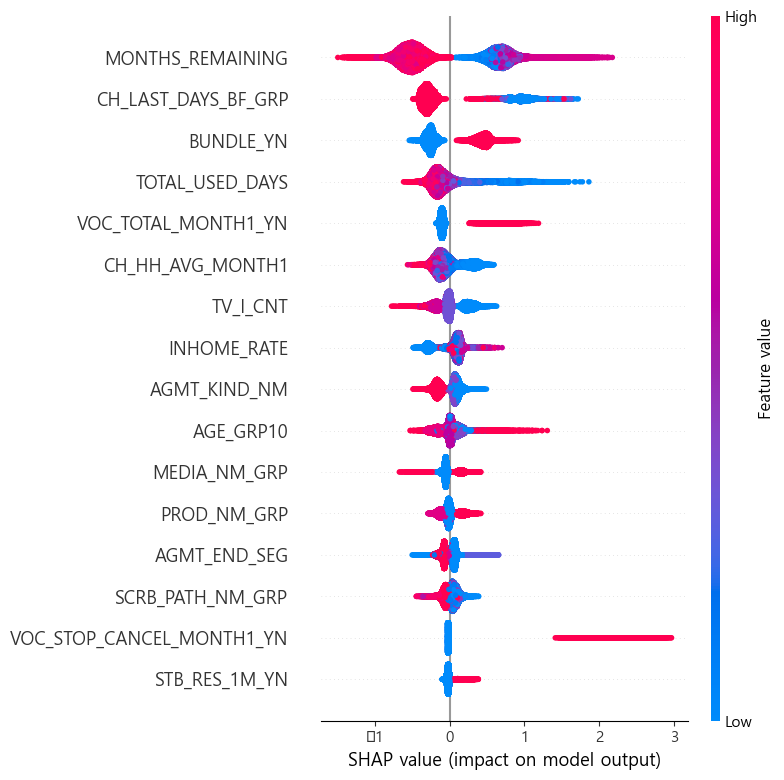

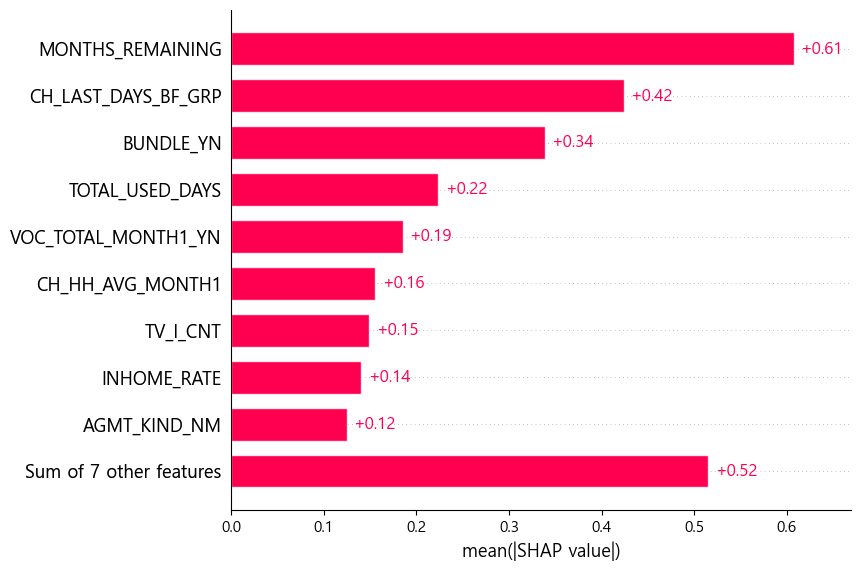

TypeError: decision() missing 1 required positional argument: 'shap_values'

In [17]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 3. 데이터 샘플링
sample_size = 90000  # 샘플 크기 설정 (데이터 크기에 맞게 조정 가능)
df_shap_sampled = df_modeling.sample(n=sample_size, random_state=42)

print(f"✅ 데이터 샘플링 완료! (샘플 크기: {len(df_shap_sampled)})")

# ✅ 4. SHAP Explainer 최적화
explainer = shap.TreeExplainer(
    loaded_model,
    data=df_shap_sampled, 
    model_output="margin"
)

# ✅ 5. SHAP 값 계산
shap_values = explainer(df_shap_sampled)

print("✅ SHAP 값 계산 완료!")

# ✅ 6. SHAP Summary Plot (Feature Importance 시각화)
shap.summary_plot(shap_values, df_shap_sampled)

# ✅ 7. 추가적인 SHAP 분석
# 1️⃣ Feature 중요도 (막대 그래프)
shap.plots.bar(shap_values)

# 2️⃣ 특정 샘플의 예측 과정 해석 (0번째 샘플)
shap.plots.force(shap_values[0])
print("✅ SHAP 분석 완료!")

1. `BUNDLE_YN`
- 파란색 (0, 미가입 고객)은 왼쪽 방향에 위치, 빨간색 (1, 가입 고객)은 오른쪽 방향에 위치
- SHAP 값 음수 = 이탈 가능성이 낮아짐
- SHAP 값 양수 = 이탈 가능성이 높아짐
- 번들 미가입 고객은 이탈 가능성이 낮음
- 번들 가입 고객은 **이탈 가능성이 높음**

2. `CH_LAST_DAYS_BF_GRP` 
- 0 : 2주일전 / 1 : 3개월내없음 / 2 : 3주일전 / 3 : 4주일전 / 4 : 일주일내 / 5 : 일주일전
- SHAP 값 음수 = 이탈 가능성이 낮아짐
- SHAP 값 양수 = 이탈 가능성이 높아짐
- Feature의 값이 클수록(=빨간색) 음수 방향에 위치함. 이는 레이블 인코딩을 진행한 4~5의 값이 이탈 가능성이 낮다는 것을 의미.   
즉, 일주일내, 일주일전에서 이탈 가능성이 낮음.
- Feature의 값이 작을수록(=파란색) 양수 방향에 위치함. 이는 레이블 인코딩을 진행한 0~2의 값이 이탈 가능성이 높다는 것을 의미   
**즉, 2주일전, 3개월내없음, 3주일전에서 이탈 가능성이 높음**


3. `TOTAL_USED_DAYS`
- SHAP 값 음수 = 이탈 가능성이 낮아짐
- SHAP 값 양수 = 이탈 가능성이 높아짐
- Feature의 값이 클수록(=빨간색) 음수 방향에 위치함. 이는 총 사용일수가 높은 고객들의 이탈 가능성이 낮다는 것을 의미.   
즉, 충성고객일수록 해지를 하지 않음.
- Feature의 값이 작을수록(=파란색) 양수 방향에 위치함. 이는 총 사용일수가 적은 고객들의 이탈 가능성이 높다는 것을 의미   
**즉, 총 사용일수가 적을수록 해지를 하는 경향을 보임**


4. `MONTH_REMAINING`
- MONTH_REMAINING 컬럼은 -230 ~ 48의 값을 가짐 -> minmax스케일링을 진행함.
- SHAP 값 음수 = 이탈 가능성이 낮아짐
- SHAP 값 양수 = 이탈 가능성이 높아짐
- 남은 개월 수가 0에 가까울수록 즉, shap의 색깔이 파란색일수록 값이 왼쪽에 위치함.<br>즉, **계약이 많이 지났거나, 계약 종료일에 가까운 고객들이 해지를 많이하는 경향을 보임.**
- 남은 개월수가 1에 가까워질수록 shap의 색깔은 빨강색이고, 값이 왼쪽에 더 많이 위치함.<br>즉, **남은 개월수가 많을수록 유지가능성이 높음.**


5. `CH_HH_AVG_MONTH1`
- SHAP 값 음수 = 이탈 가능성이 낮아짐
- SHAP 값 양수 = 이탈 가능성이 높아짐
- TV 시청 시간이 높을수록(빨간색) 왼쪽에 위치함.<br>즉, TV를 많이 볼수록 유지를 하는 경향을 보임.
- TV 시청 시간이 적을수록(파란색) 오른쪽에 위치함.<br>즉, **TV를 보지 않을수록 해지를 하는 경향을 보임.** 


이런식으로, shap 분석을 하면 됨.